In [50]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from dsn.util.systems import system_from_str
from dsn.train_dsn import train_dsn
import seaborn as sns
import pandas as pd
import warnings
import scipy
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
system_D = 2;
system_str = 'linear_%dD' % system_D;

behavior_str = 'oscillation';

system_class = system_from_str(system_str);
system = system_class(behavior_str);


In [63]:
# create test parameter grid
bound = 30;
start = -30.0;
stop = 30.0;
res = 5;
eps = .001;
vals = np.arange(start, stop+eps, res);
num_pts = vals.shape[0];

total_pts = num_pts**4;
params = np.zeros((total_pts,4));
T_a_valid = np.zeros((total_pts, 6));
ind = 0;
for i in range(num_pts):
    a1 = vals[i];
    for j in range(num_pts):
        a2 = vals[j];
        for k in range(num_pts):
            a3 = vals[k];
            for l in range(num_pts):
                a4 = vals[l];
                params[ind,:] = np.array([a1, a2, a3, a4]);
                if ((a1 + a4)**2 >= 4*(a1*a4 + a2*a3)):
                    lambda_1_real = 0.5*((a1+a4) + np.sqrt((a1 + a4)**2 - 4*(a1*a4 + a2*a3)));
                    lambda_2_real = 0.5*((a1+a4) - np.sqrt((a1 + a4)**2 - 4*(a1*a4 + a2*a3)));
                    lambda_1_imag = 0.0;
                else:
                    if ((a1 + a4) == 0):
                        lambda_1_real = 0.0;
                        lambda_2_real = 0.0;
                        lambda_1_imag = np.sqrt(a1*a4 + a2*a3);
                    else:
                        lambda_1_real = (a1+a4)/2.0;
                        lambda_2_real = (a1+a4)/2.0;
                        lambda_1_imag = np.sqrt(4*(a1*a4 + a2*a3) - (a1 + a4)**2)/2.0;
                T_a_valid[ind,:] = np.array([lambda_1_real, np.square(lambda_1_real), \
                                             lambda_2_real, np.square(lambda_2_real), \
                                             lambda_1_imag, np.square(lambda_1_imag)]);
                if (np.count_nonzero(np.isnan(T_a_valid[ind,:])) > 0):
                    print('found nans');
                    print(a1,a2,a3,a4);
                    print(T_a_valid[ind,:])
                ind += 1;


print(np.count_nonzero(np.isnan(T_a_valid)));
print(np.count_nonzero(np.isinf(T_a_valid)));

0
0


In [64]:
num_params = system.D;
K = 1;
M = total_pts;
phi = tf.placeholder(dtype=tf.float64, shape=(K, M, num_params, 1));

T_a = system.analytic_suff_stats(phi);

_phi = np.expand_dims(np.expand_dims(params, 0), 3);

phi (1, 28561, 4, 1)


In [65]:
with tf.Session() as sess:
    _T_a = sess.run(T_a, {phi:_phi});
mu = [0.0, 1.0, 12.56637061, 158.91367042];
    
nsamps = _phi.shape[1];
distance = np.zeros((nsamps,));
for i in range(nsamps):
    distance[i] = np.linalg.norm(_T_a[0,i,:] - mu);
print(distance)

[1165.59593313 1054.25023014  950.30000977 ...  950.30000977 1054.25023014
 1165.59593313]


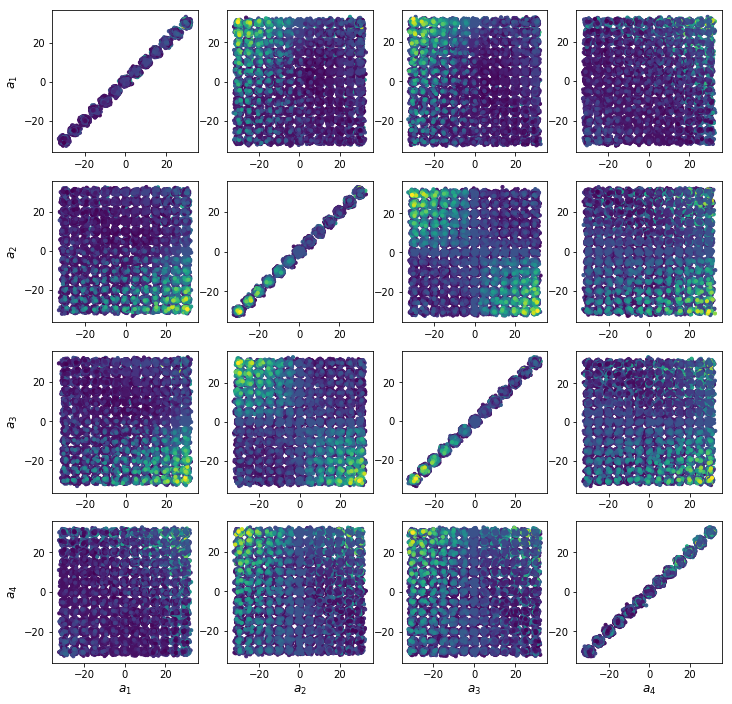

In [66]:
inds = np.random.permutation(nsamps);
jitter_std = 0.8;
figsize = (12,12);
fontsize = 12;
plt.figure(figsize=figsize);
for i in range(system.D):
    for j in range(system.D):
        ind = system.D*i + j + 1;
        plt.subplot(system.D, system.D, ind);
        jitter_x = np.random.normal(0,jitter_std,(nsamps,));
        jitter_y = np.random.normal(0,jitter_std,(nsamps,));
        plt.scatter(_phi[0,:,j,0]+jitter_x, _phi[0,:,i,0]+jitter_y, s=10, c=distance);
        if (i==3):
            plt.xlabel(r'$a_%d$' % (j+1), fontsize=fontsize);
        if (j==0):
            plt.ylabel(r'$a_%d$' % (i+1), fontsize=fontsize);

plt.show();

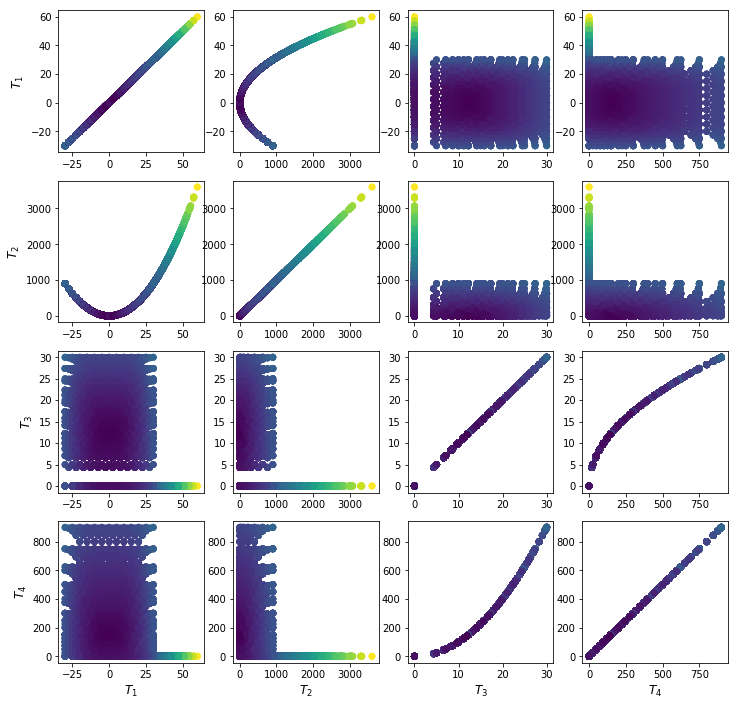

In [67]:
plt.figure(figsize=figsize);
for i in range(system.D):
    for j in range(system.D):
        ind = system.D*i + j + 1;
        plt.subplot(system.D, system.D, ind);
        plt.scatter(_T_a[0,:,j], _T_a[0,:,i], c=distance);
        if (i==3):
            plt.xlabel(r'$T_%d$' % (j+1), fontsize=fontsize);
        if (j==0):
            plt.ylabel(r'$T_%d$' % (i+1), fontsize=fontsize);

plt.show();




In [20]:
print(_T_a.shape)

(1, 14641, 4)
